In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow import keras

print('슝=3')

슝=3


# KITTI 데이터셋 수집과 구축

In [3]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
              }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [4]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

In [5]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# U-Net ++ 모델의 구현

참고 자료들
- [UNet++: Implementation of the UNet++ architecture on TensorFlow for segmentation of cell nuclei (Medium)](https://medium.com/mlearning-ai/unet-implementation-of-the-unet-architecture-on-tensorflow-for-segmentation-of-cell-nuclei-528b5b6e6ffd)
- [참고 Github](https://github.com/MrGiovanni/UNetPlusPlus/blob/master/keras/helper_functions.py#L199)

In [6]:
import tensorflow as tf
import numpy as np
import PIL
import skimage
import albumentations
from tensorflow import keras

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.6.0
1.21.4
8.3.2
0.18.3
1.1.0


## UNet++ 구조 이해하기
---

![U-net++](asset/UNet++.png)   

>U-Net에 DenseNet의 아이디어가 차용된 버전.   

![U-net++ 상세설명](asset/UNet++_상세설명.png)

U-net 구현하고 수정해보자

## U-net 구현

In [105]:
def ConvBlock(x, n_filters):
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    return x

def EncoderBlock(x, n_filters):
    p = ConvBlock(x, n_filters)
    x = keras.layers.MaxPooling2D(2)(p)
    
    return x, p

def DecoderBlock(x, skip, n_filters):
    x = keras.layers.Conv2DTranspose(n_filters, (2, 2), strides=2, padding='same')(x)
    x = keras.layers.Concatenate()([x, skip]) 
    x = ConvBlock(x, n_filters)
    
    return x

def Unet(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    # 축소 경로
    skips = []
    
    filters = [64, 128, 256, 512, 1024]
    for i, f in enumerate(filters):
        if i == 0:
            x, p = EncoderBlock(inputs, f)
            skips.append(p)
        elif i == len(filters)-1:
            x = ConvBlock(x, f)
        else:
            x, p = EncoderBlock(x, f)
            skips.append(p)
    
    # 확장 경로
    for skip, f in zip(skips[::-1], filters[:-1][::-1]):
        x = DecoderBlock(x, skip, f)
    
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'
        
    outputs = keras.layers.Conv2D(num_classes, 1, padding='same', activation=activation)(x)
    
    model = keras.Model(inputs, outputs)
    
    return model

In [106]:
unet = Unet(img_size=(224, 224), num_classes=1)

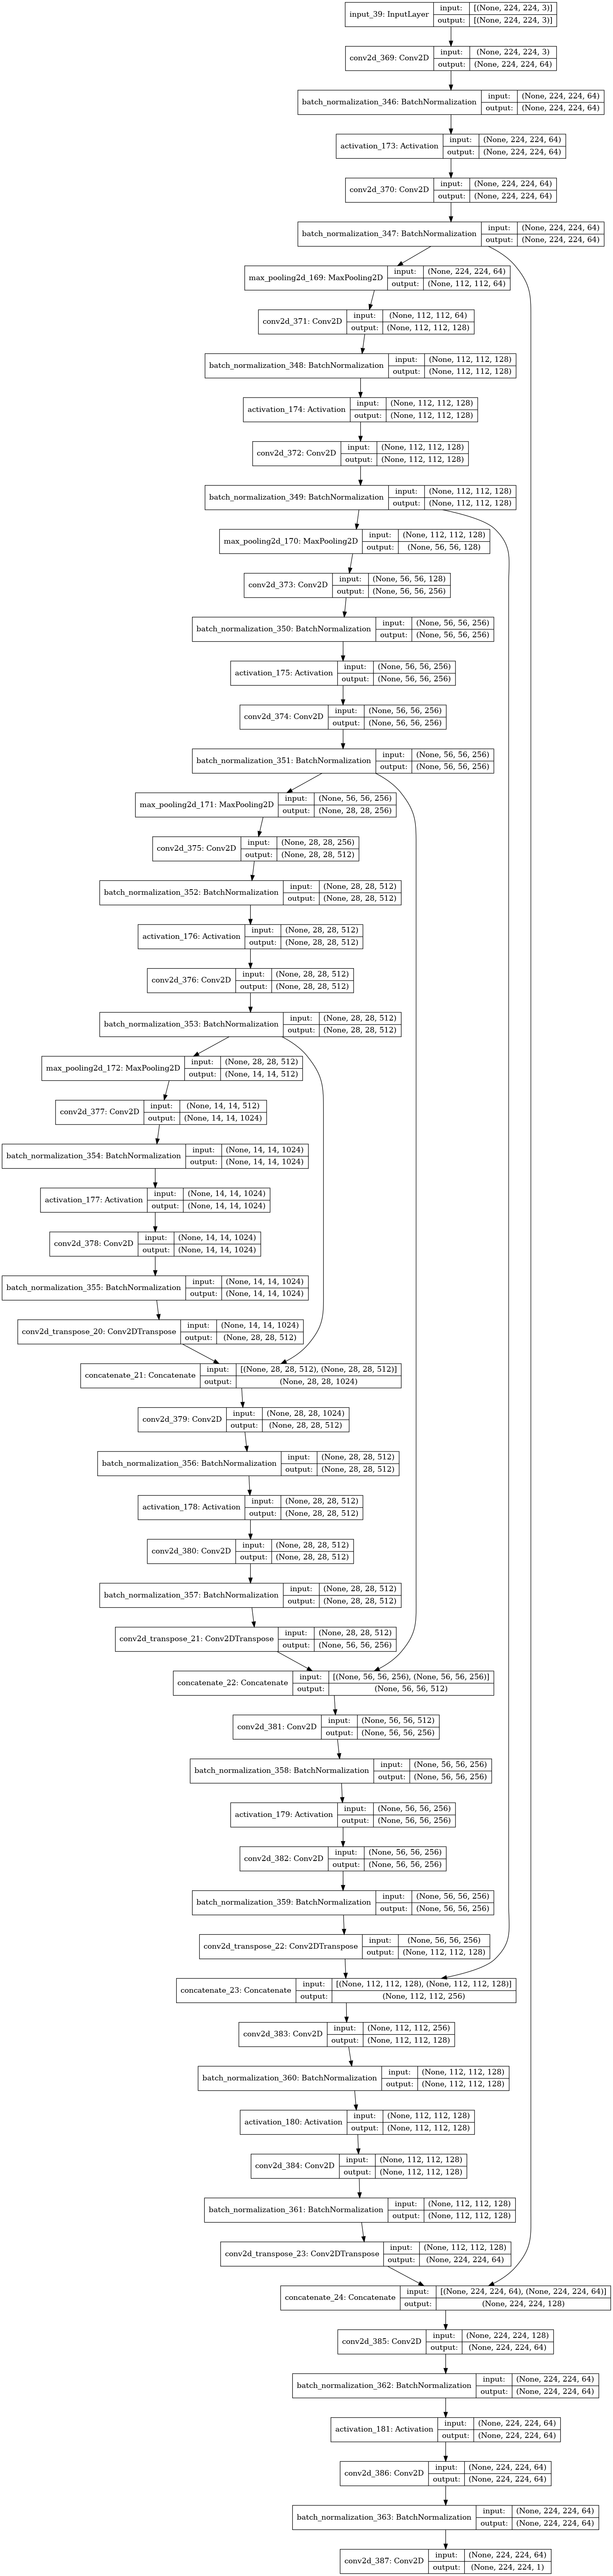

In [108]:
keras.utils.plot_model(unet, show_shapes=True)

In [112]:
# !pip install visualkeras

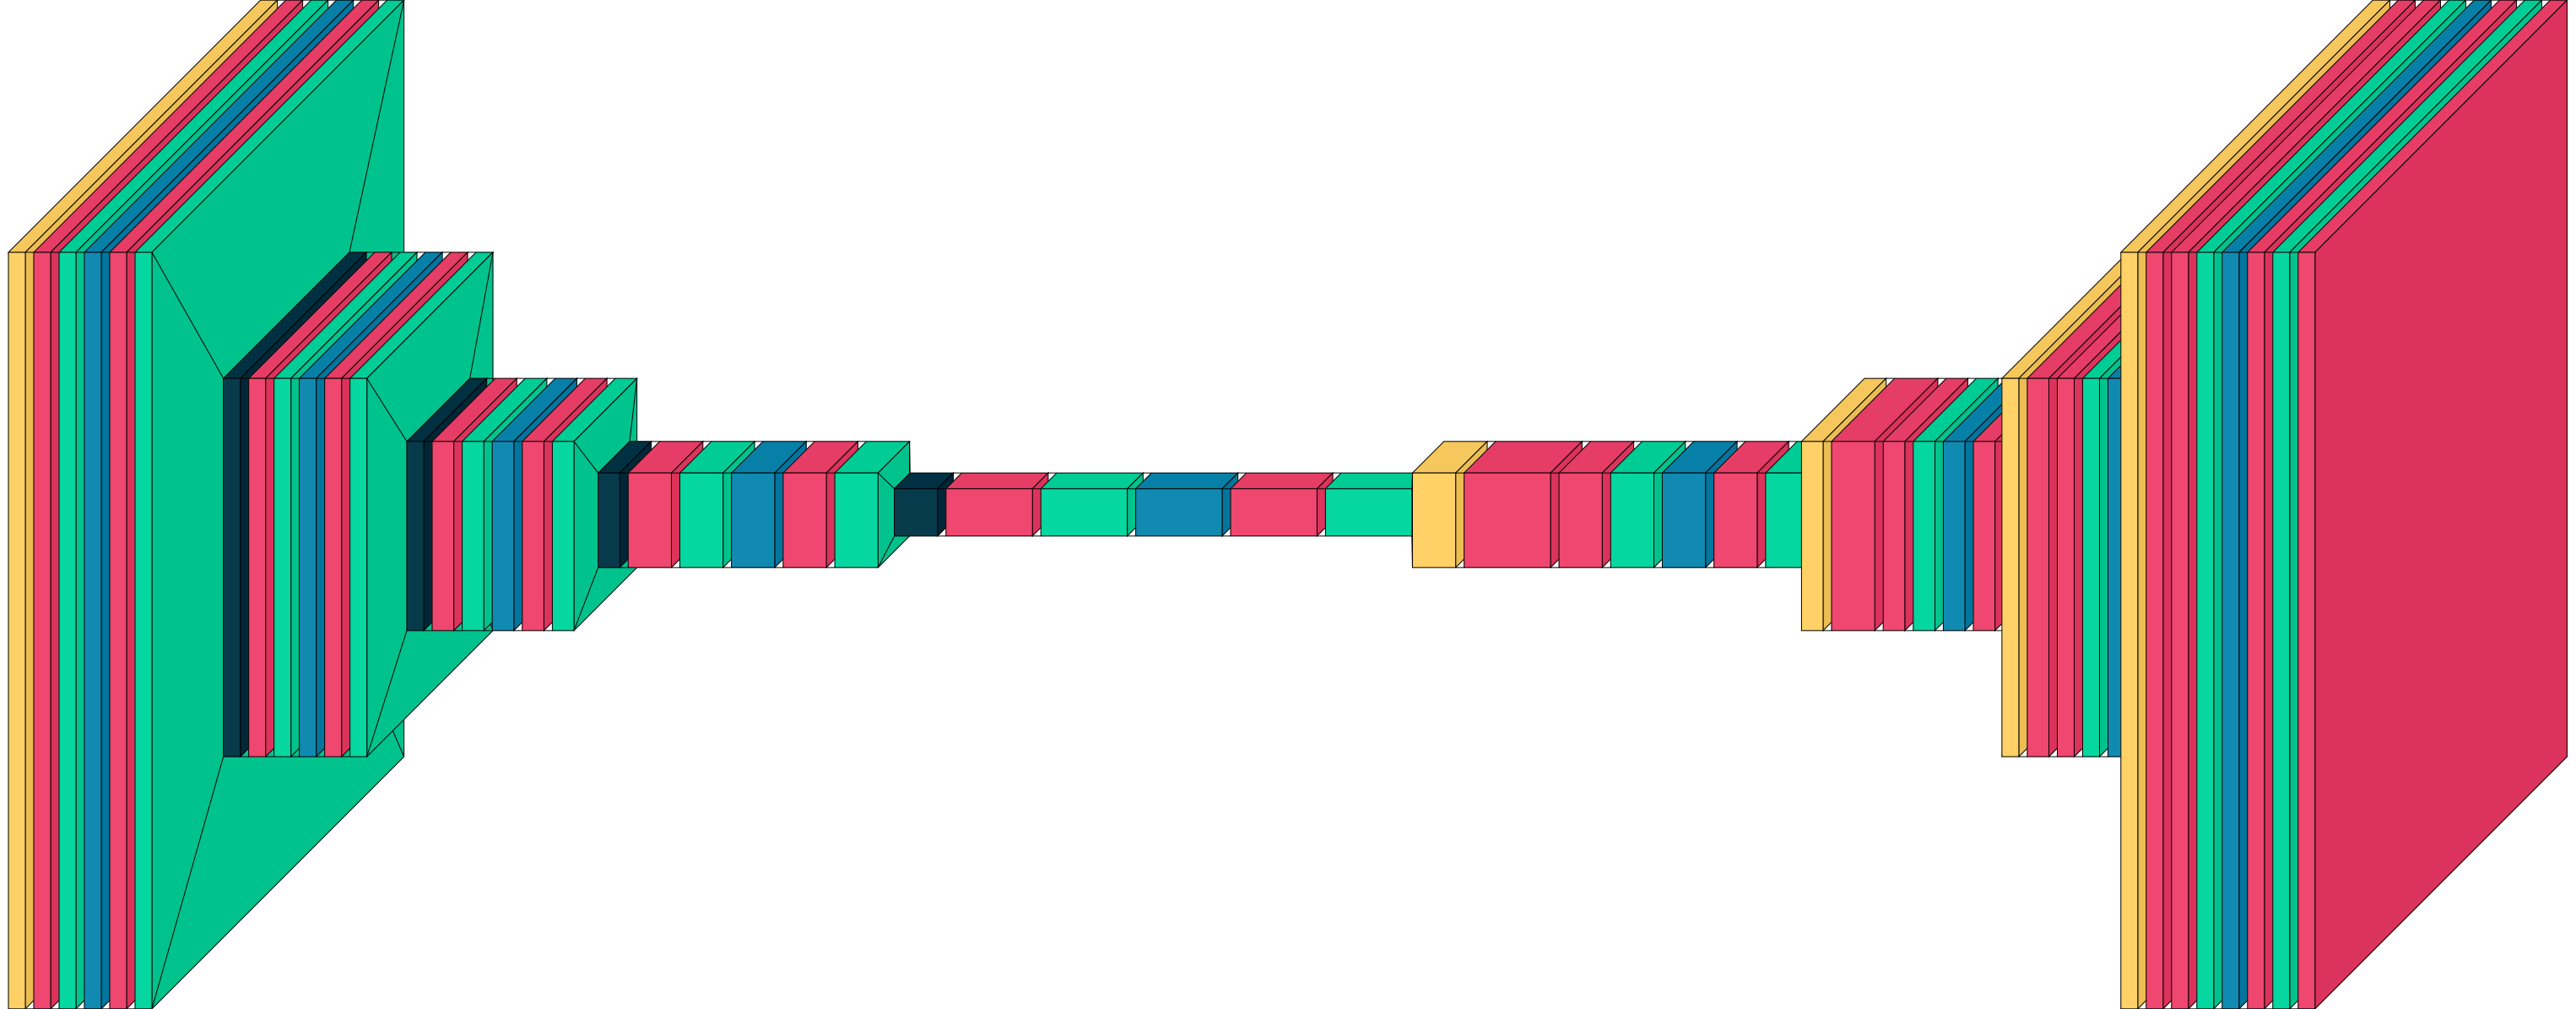

In [116]:
import visualkeras

visualkeras.layered_view(unet)
# 연결 구조가 안나와서 아쉽다

## U-net++ 구현

어렵네...   
단계별로 구현하자

In [176]:
def ConvBlock(x, n_filters):
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    return x

def EncoderBlock(x, n_filters):
    p = ConvBlock(x, n_filters)
    x = keras.layers.MaxPooling2D(2)(p)
    
    return x, p 

def DecoderBlock(x, skip, n_filters):
    x = keras.layers.Concatenate()([x, *skip]) 
    x = ConvBlock(x, n_filters)
    x = UpBlock(x, n_filters)
    
    return x

def UpBlock(x, n_filters):
    x = keras.layers.Conv2DTranspose(n_filters, (2, 2), strides=2, padding='same')(x)
    
    return x

### U-net++ L1
---
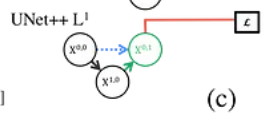

In [130]:
img_size=(224, 224)
num_classes=1
filters = [64, 128, 256, 512, 1024]

inputs = keras.Input(shape=img_size + (3,))

# 변수명 정리
# 아래로 가는 것들 x, 옆으로 가는 것들  p, 위로 가는 것들 u, 합쳐진 인풋 i

# X_0_0
x_0_0, p_0_0 = EncoderBlock(inputs, filters[0])
# X_1_0
u_1_0 = UpBlock(x_0_0, filters[1])
# X_0_1
i_0_1 =  keras.layers.Concatenate()([p_0_0, u_1_0]) 

output_0_1 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_1)

UNet_pp_L1 = keras.Model(inputs, output_0_1)

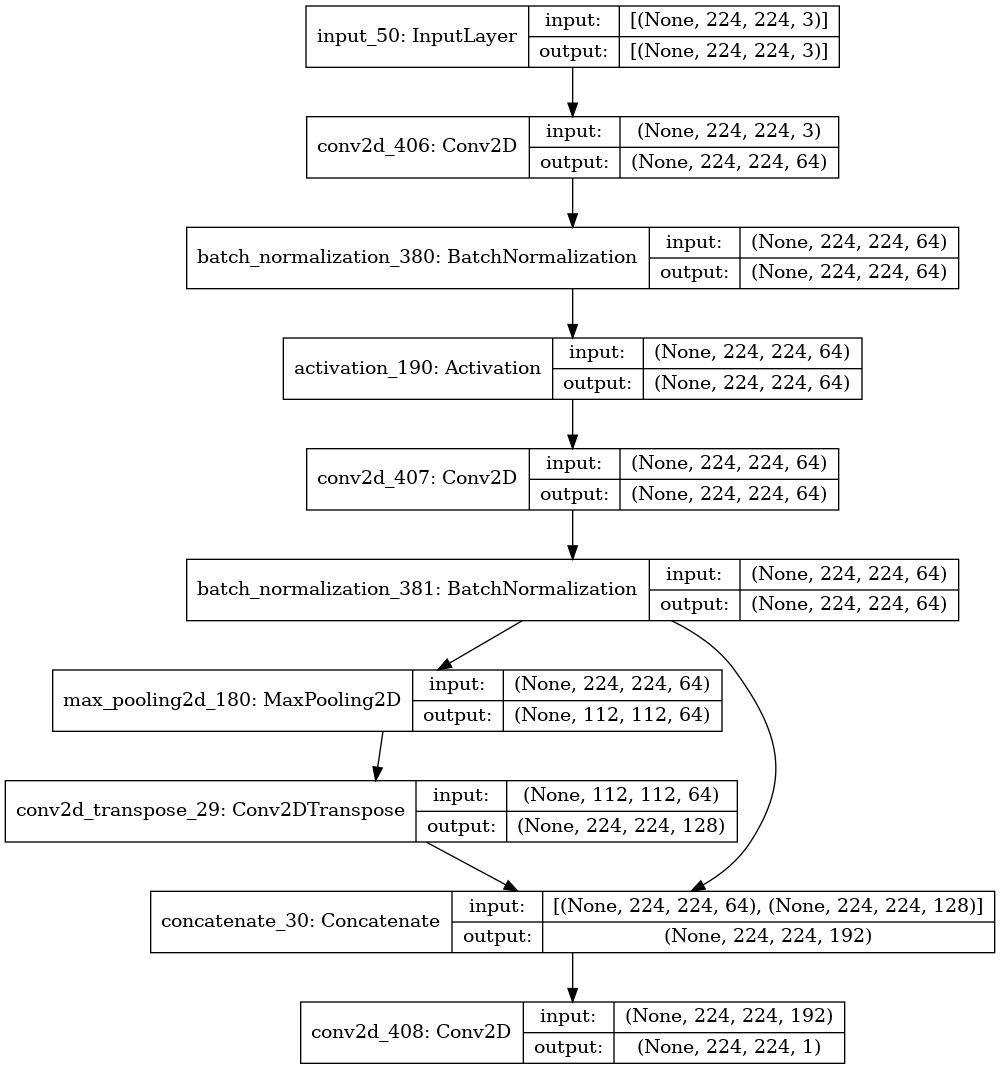

In [131]:
keras.utils.plot_model(UNet_pp_L1, show_shapes=True)

### U-net++ L2
---
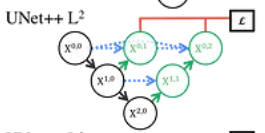

In [136]:
img_size=(224, 224)
num_classes=1
filters = [64, 128, 256, 512, 1024]

inputs = keras.Input(shape=img_size + (3,))

# 변수명 정리
# 아래로 가는 것들 x, 옆으로 가는 것들  p, 위로 가는 것들 u, 합쳐진 인풋 i, 출력값 o
# x와 p 차이는 max pooling 적용 여부

# X_0_0
x_0_0, p_0_0 = EncoderBlock(inputs, filters[0])

# X_1_0
u_1_0 = UpBlock(x_0_0, filters[1])
x_1_0, p_1_0 = EncoderBlock(x_0_0, filters[1])

# X_2_0
u_2_0 = UpBlock(x_1_0, filters[2])

# X_0_1
i_0_1 =  keras.layers.Concatenate()([p_0_0, u_1_0]) 
o_0_1 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_1)
p_0_1 = ConvBlock(i_0_1, filters[1])

# X_1_1
i_1_1 =  keras.layers.Concatenate()([p_1_0, u_2_0]) 
u_1_1 = UpBlock(i_1_1, filters[2])

# X_0_2
i_0_2 =  keras.layers.Concatenate()([p_0_1, u_1_1, p_0_0]) 
o_0_2 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_2)

outputs = keras.layers.Average()([o_0_1, o_0_2])
UNet_pp_L2 = keras.Model(inputs, outputs)

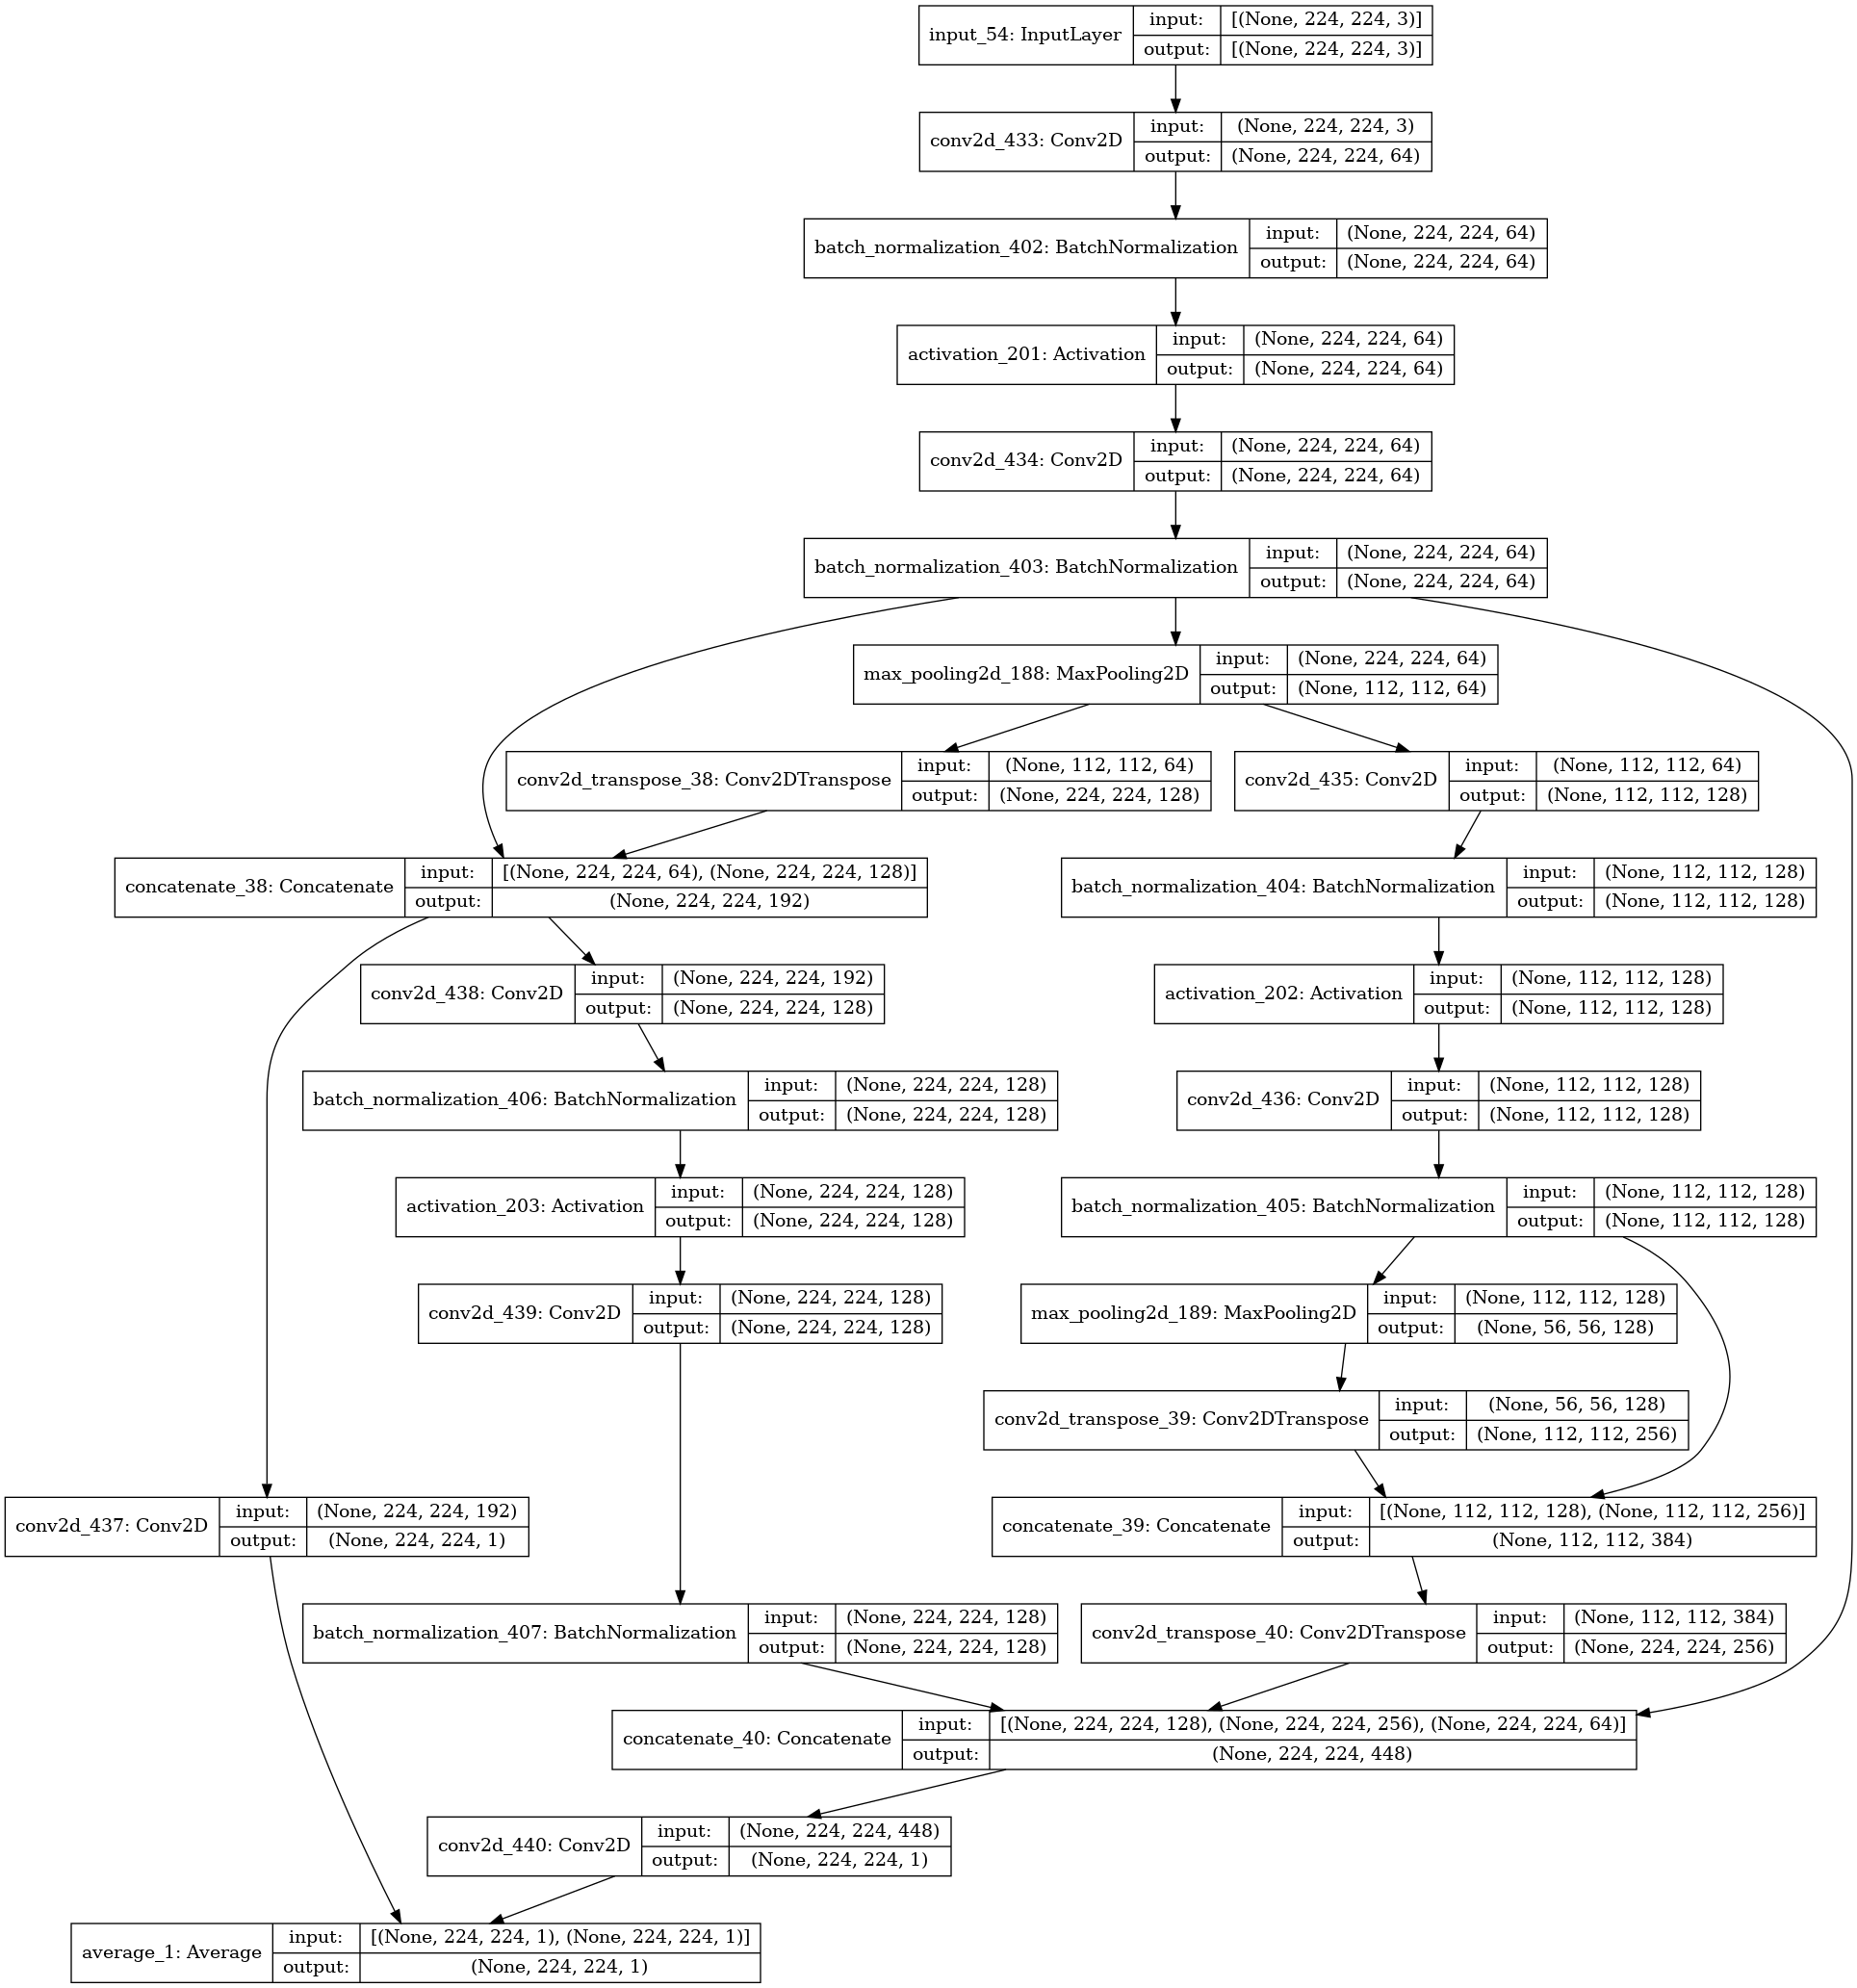

In [138]:
keras.utils.plot_model(UNet_pp_L2, show_shapes=True)

### U-net++ L4
---
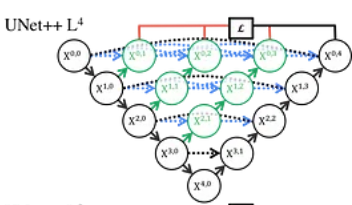

In [21]:
img_size=(224, 224)
num_classes=1
# filters = [64, 128, 256, 512, 1024]
filters = [32,64,128,256,512]


inputs = keras.Input(shape=img_size + (3,))

# 변수명 정리
# 진한 검은색 : x (인코더에서는 아래로, 디코더에서는 위로)
# 점선 파란색 : p (옆으로 가는 것들)  
# 진한 초록색 : u (위로 가는 것들) 
# 합쳐진 인풋 : i
# 빨간색 (출력값) : o

# x와 p 차이는 max pooling 적용 여부

# Encoder 부분

# X_0_0
x_0_0, p_0_0 = EncoderBlock(inputs, filters[0])

# X_1_0
u_1_0 = UpBlock(x_0_0, filters[1])
x_1_0, p_1_0 = EncoderBlock(x_0_0, filters[1])

# X_2_0
u_2_0 = UpBlock(x_1_0, filters[2])
x_2_0, p_2_0 = EncoderBlock(x_1_0, filters[2])

# X_3_0
u_3_0 = UpBlock(x_2_0, filters[3])
x_3_0, p_3_0 = EncoderBlock(x_2_0, filters[3])


# 초록색 부분

# X_0_1
i_0_1 =  keras.layers.Concatenate()([p_0_0, u_1_0]) 
o_0_1 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_1)
p_0_1 = ConvBlock(i_0_1, filters[0])

# X_1_1
i_1_1 =  keras.layers.Concatenate()([p_1_0, u_2_0]) 
u_1_1 = UpBlock(i_1_1, filters[1])
p_1_1 = ConvBlock(i_1_1, filters[0])

# X_2_1
i_2_1 =  keras.layers.Concatenate()([p_2_0, u_3_0]) 
u_2_1 = UpBlock(i_2_1, filters[1])
p_2_1 = ConvBlock(i_2_1, filters[0])

# X_0_2
i_0_2 =  keras.layers.Concatenate()([p_0_1, u_1_1, p_0_0]) 
o_0_2 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_2)
p_0_2 = ConvBlock(i_0_2, filters[0])


# X_1_2
i_1_2 =  keras.layers.Concatenate()([p_1_1, u_2_1, p_1_0]) 
u_1_2 = UpBlock(i_1_2, filters[1])
p_1_2 = ConvBlock(i_1_2, filters[0])

# X_0_3
i_0_3 =  keras.layers.Concatenate()([p_0_1, u_1_2, p_0_0, p_0_2]) 
o_0_3 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_3)
p_0_3 = ConvBlock(i_0_3, filters[0])

# Decoder 부분

# X_4_0
x_4_0 = DecoderBlock(x_3_0, [], filters[4])

# X_3_1
x_3_1 = DecoderBlock(x_4_0, [p_3_0], filters[3])

# X_2_2
x_2_2 = DecoderBlock(x_3_1, [p_2_1, p_2_0], filters[2])

# X_1_3
x_1_3 = DecoderBlock(x_2_2, [p_1_2, p_1_1, p_1_0], filters[1])

# X_0_4
i_0_4 =  keras.layers.Concatenate()([x_1_3, p_0_0, p_0_1, p_0_2, p_0_3])
o_0_4 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_4)

outputs = keras.layers.Average()([o_0_1, o_0_2, o_0_3, o_0_4])
UNet_pp_L4 = keras.Model(inputs, outputs)

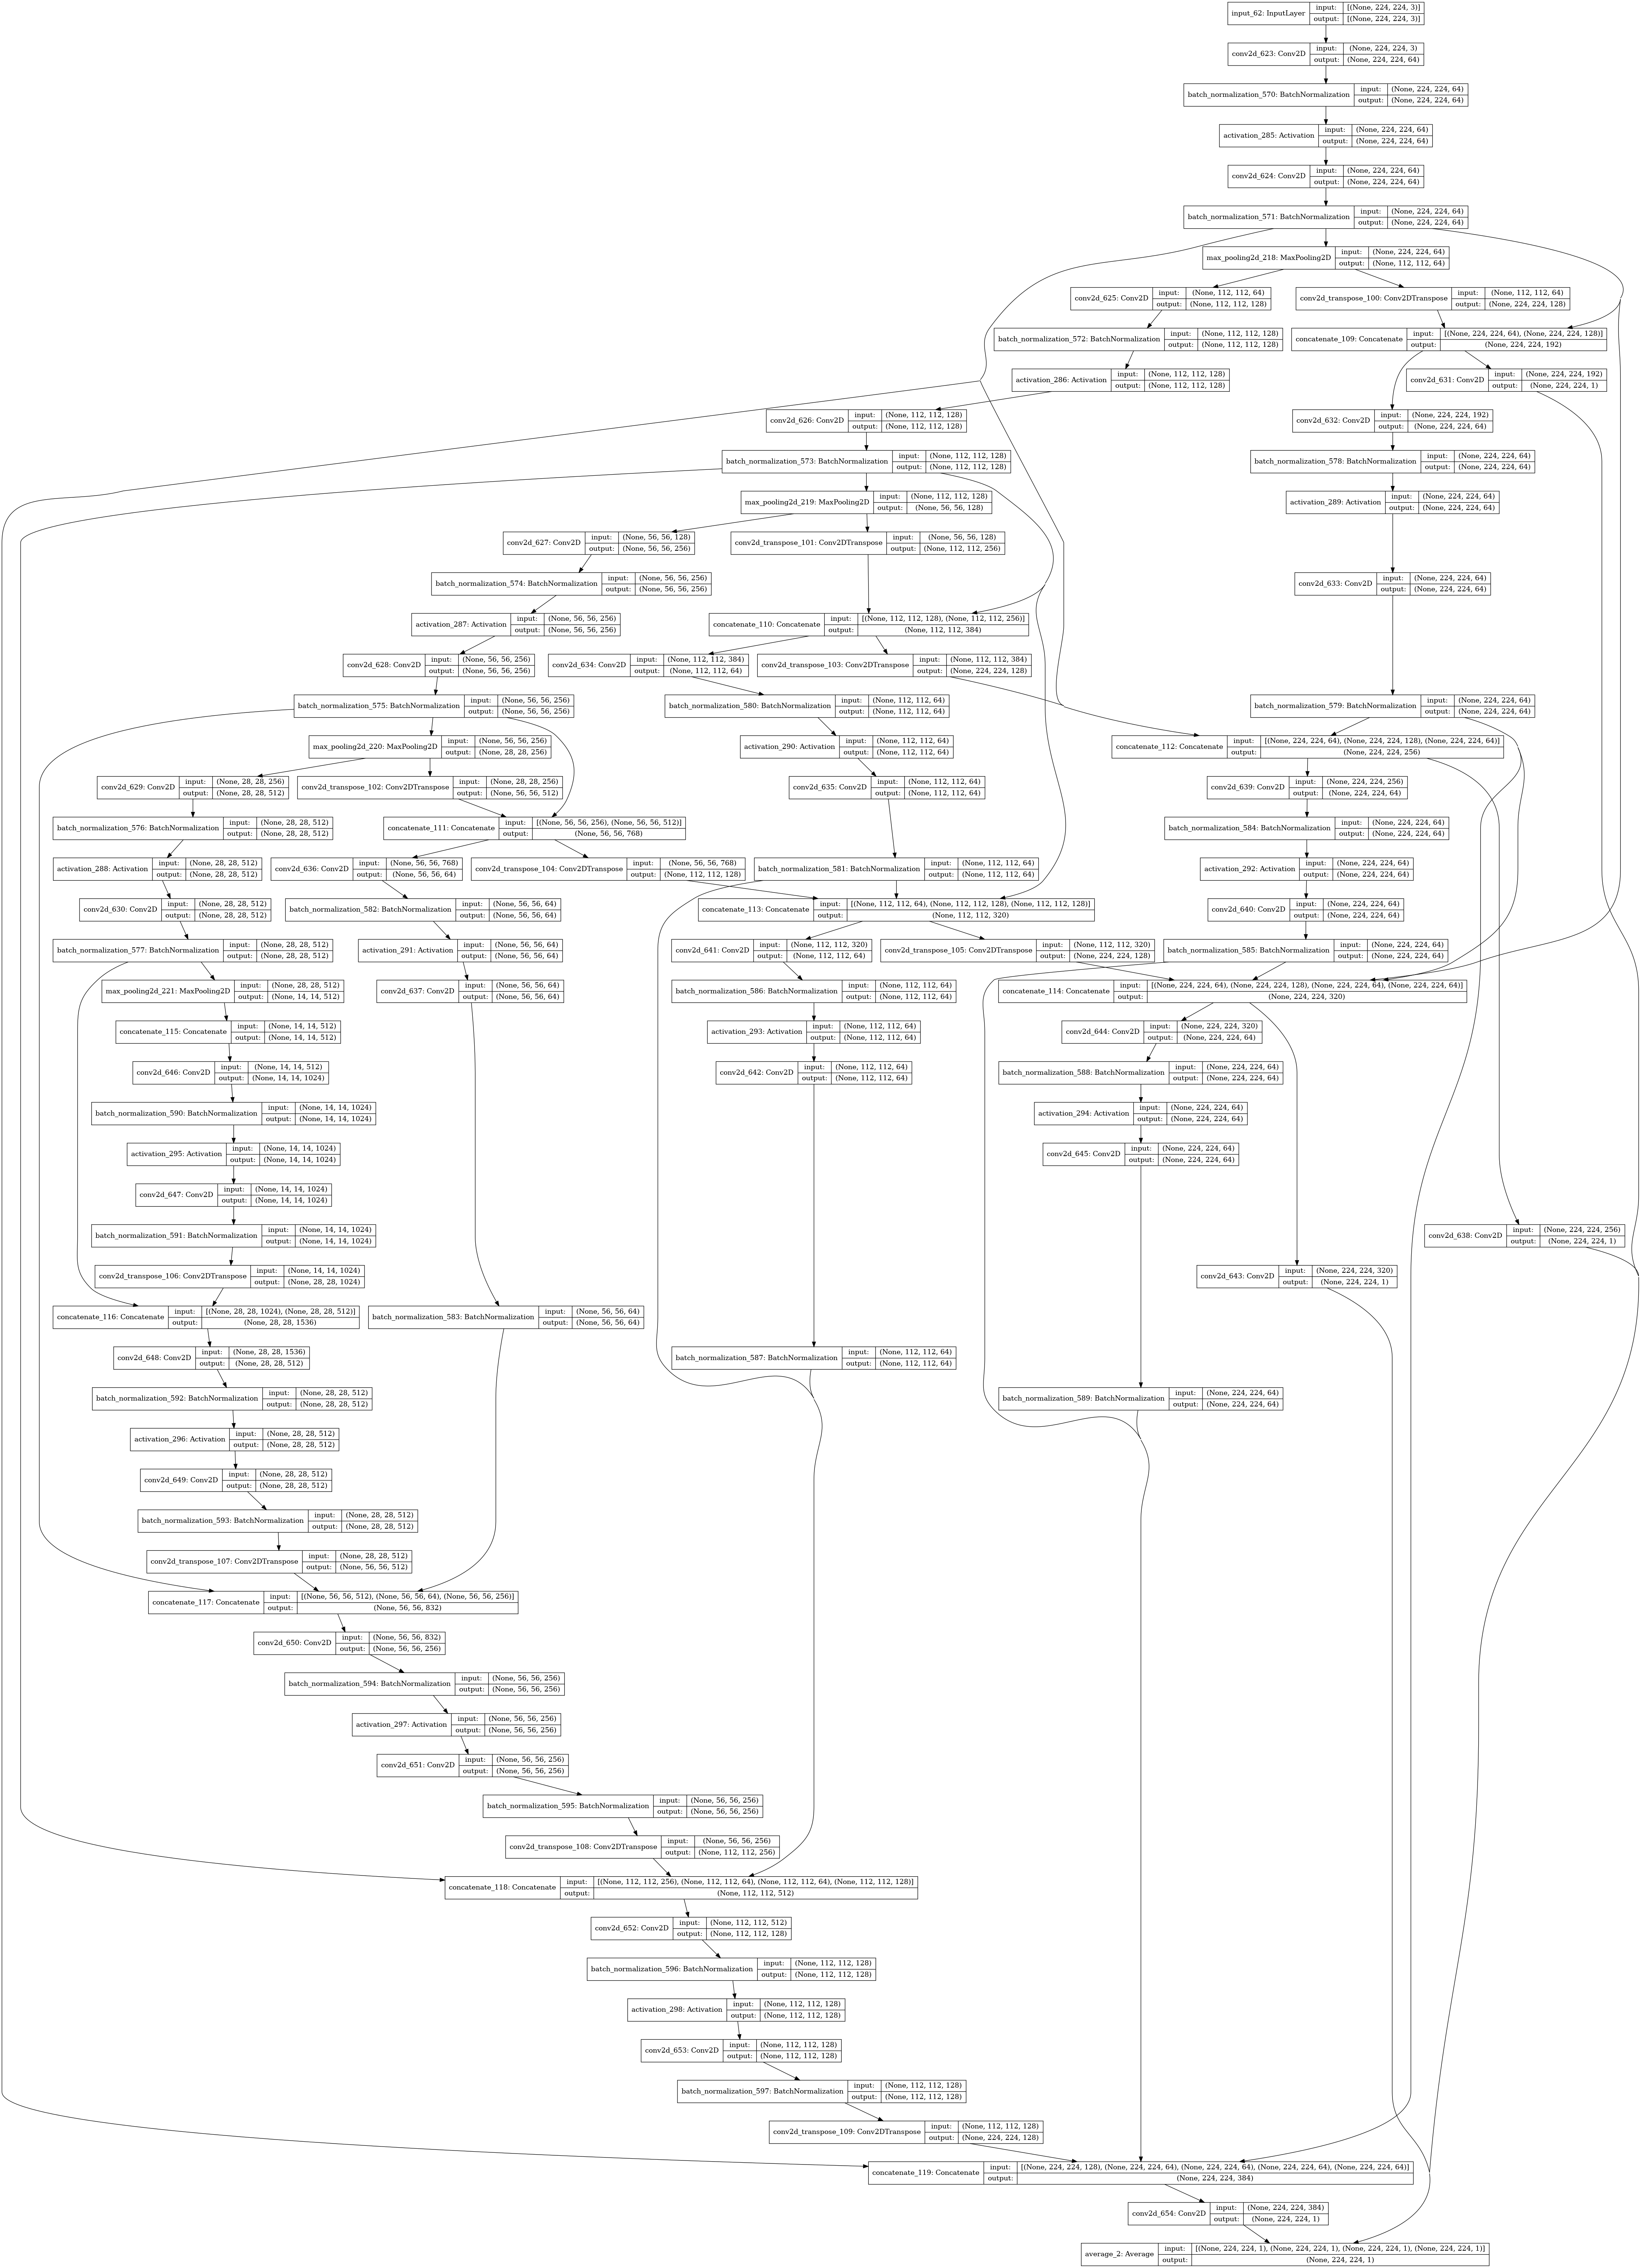

In [186]:
keras.utils.plot_model(UNet_pp_L4, show_shapes=True)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
# 함수화 하기

def ConvBlock(x, n_filters):
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    return x

def EncoderBlock(x, n_filters):
    p = ConvBlock(x, n_filters)
    x = keras.layers.MaxPooling2D(2)(p)
    
    return x, p 

def DecoderBlock(x, skip, n_filters):
    x = keras.layers.Concatenate()([x, *skip]) 
    x = ConvBlock(x, n_filters)
    x = UpBlock(x, n_filters)
    
    return x

def UpBlock(x, n_filters):
    x = keras.layers.Conv2DTranspose(n_filters, (2, 2), strides=2, padding='same')(x)
    
    return x

def build_UNetPP(img_size=(224, 224), num_classes=1, filters = [64, 128, 256, 512, 1024]):
    inputs = keras.Input(shape=img_size + (3,))

    # 변수명 정리
    # 진한 검은색 : x (인코더에서는 아래로, 디코더에서는 위로)
    # 점선 파란색 : p (옆으로 가는 것들)  
    # 진한 초록색 : u (위로 가는 것들) 
    # 합쳐진 인풋 : i
    # 빨간색 (출력값) : o

    # x와 p 차이는 max pooling 적용 여부

    # Encoder 부분
    
    # X_0_0
    x_0_0, p_0_0 = EncoderBlock(inputs, filters[0])

    # X_1_0
    u_1_0 = UpBlock(x_0_0, filters[1])
    x_1_0, p_1_0 = EncoderBlock(x_0_0, filters[1])

    # X_2_0
    u_2_0 = UpBlock(x_1_0, filters[2])
    x_2_0, p_2_0 = EncoderBlock(x_1_0, filters[2])

    # X_3_0
    u_3_0 = UpBlock(x_2_0, filters[3])
    x_3_0, p_3_0 = EncoderBlock(x_2_0, filters[3])


    # 초록색 부분
    
    # X_0_1
    i_0_1 =  keras.layers.Concatenate()([p_0_0, u_1_0]) 
    o_0_1 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_1)
    p_0_1 = ConvBlock(i_0_1, filters[0])

    # X_1_1
    i_1_1 =  keras.layers.Concatenate()([p_1_0, u_2_0]) 
    u_1_1 = UpBlock(i_1_1, filters[1])
    p_1_1 = ConvBlock(i_1_1, filters[0])

    # X_2_1
    i_2_1 =  keras.layers.Concatenate()([p_2_0, u_3_0]) 
    u_2_1 = UpBlock(i_2_1, filters[1])
    p_2_1 = ConvBlock(i_2_1, filters[0])

    # X_0_2
    i_0_2 =  keras.layers.Concatenate()([p_0_1, u_1_1, p_0_0]) 
    o_0_2 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_2)
    p_0_2 = ConvBlock(i_0_2, filters[0])


    # X_1_2
    i_1_2 =  keras.layers.Concatenate()([p_1_1, u_2_1, p_1_0]) 
    u_1_2 = UpBlock(i_1_2, filters[1])
    p_1_2 = ConvBlock(i_1_2, filters[0])

    # X_0_3
    i_0_3 =  keras.layers.Concatenate()([p_0_1, u_1_2, p_0_0, p_0_2]) 
    o_0_3 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_3)
    p_0_3 = ConvBlock(i_0_3, filters[0])

    # Decoder 부분

    # X_4_0
    x_4_0 = DecoderBlock(x_3_0, [], filters[4])

    # X_3_1
    x_3_1 = DecoderBlock(x_4_0, [p_3_0], filters[3])

    # X_2_2
    x_2_2 = DecoderBlock(x_3_1, [p_2_1, p_2_0], filters[2])

    # X_1_3
    x_1_3 = DecoderBlock(x_2_2, [p_1_2, p_1_1, p_1_0], filters[1])

    # X_0_4
    i_0_4 =  keras.layers.Concatenate()([x_1_3, p_0_0, p_0_1, p_0_2, p_0_3])
    o_0_4 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_4)

    outputs = keras.layers.Average()([o_0_1, o_0_2, o_0_3, o_0_4])
    model = keras.Model(inputs, outputs)

    return model

## 학습시키기

In [ ]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetPP.h5'

model = build_UNetPP()
model.compile(optimizer = Adam(1e-4), loss ='binary_crossentropy')

In [11]:
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=30,
 )

model.save(model_path) 

Epoch 1/30
43/43 [==============================] - 23s 540ms/step - loss: 11.8539 - val_loss: 11.7388
Epoch 2/30
43/43 [==============================] - 24s 548ms/step - loss: 11.6162 - val_loss: 11.7388
Epoch 3/30
43/43 [==============================] - 23s 541ms/step - loss: 11.8731 - val_loss: 11.7388
Epoch 4/30
43/43 [==============================] - 23s 539ms/step - loss: 11.9798 - val_loss: 11.7388
Epoch 5/30
43/43 [==============================] - 23s 543ms/step - loss: 11.9221 - val_loss: 11.7388
Epoch 6/30
43/43 [==============================] - 23s 542ms/step - loss: 11.6762 - val_loss: 11.7388
Epoch 7/30
43/43 [==============================] - 23s 542ms/step - loss: 11.8195 - val_loss: 11.7388
Epoch 8/30
43/43 [==============================] - 23s 542ms/step - loss: 11.6839 - val_loss: 11.7388
Epoch 9/30
43/43 [==============================] - 23s 541ms/step - loss: 11.9293 - val_loss: 11.7388
Epoch 10/30
43/43 [==============================] - 23s 542ms/step - los

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


loss func 이 binary crossentropy 일때 loss가 안줄어듬

In [15]:
from tensorflow.keras import backend as K

# binary + dice_coef 형태로 loss func 정의

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [22]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetPP.h5'

filters = [32,64,128,256,512]

model = build_UNetPP(filters=filters)
model.compile(optimizer=Adam(1e-4), loss=bce_dice_loss)

In [23]:
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=30,
 )

model.save(model_path) 

Epoch 1/30
43/43 [==============================] - 19s 236ms/step - loss: 5.6175 - val_loss: 5.4983
Epoch 2/30
43/43 [==============================] - 9s 218ms/step - loss: 5.7224 - val_loss: 5.4983
Epoch 3/30
43/43 [==============================] - 10s 220ms/step - loss: 5.6193 - val_loss: 5.4983
Epoch 4/30
43/43 [==============================] - 10s 221ms/step - loss: 5.5018 - val_loss: 5.4983
Epoch 5/30
43/43 [==============================] - 10s 222ms/step - loss: 5.5555 - val_loss: 5.4983
Epoch 6/30
43/43 [==============================] - 10s 221ms/step - loss: 5.6045 - val_loss: 5.4983
Epoch 7/30
43/43 [==============================] - 10s 221ms/step - loss: 5.6315 - val_loss: 5.4983
Epoch 8/30
43/43 [==============================] - 10s 221ms/step - loss: 5.5567 - val_loss: 5.4983
Epoch 9/30
43/43 [==============================] - 10s 220ms/step - loss: 5.6228 - val_loss: 5.4983
Epoch 10/30
 3/43 [=>............................] - ETA: 7s - loss: 4.9528

KeyboardInterrupt: 

여전히 학습이 안된다.   

# 회고
---

😀    
모델을 짜는게 처음엔 어려워보였는데, 모델의 구조를 이해하고 하나씩 짜다보니 완성할 수 있었다.   
비록 학습이 안되는 문제가 있었지만, 좋은 경험이 됐다.   
   
😅    
아쉬운 점은 문제를 파악하지 못했다는 것...   
모델이 엄청 복잡해지니까 어디서부터 잘못짜는지 파악하기가 어렵다.   
1. 일단 다른 사람이 짠 모델을 보고 이해해보고 
2. 내가 짠거랑 비교해보고
3. 수정해봐야할 것 같다.   
    
앞으로 모델을 많이 짜게 될텐데, 이를 좀 더 효율적으로 할 수 있는 방법에 대해 고민해봐야겠다.  